# Chapter 3: Eniac Data Cleaning (Exploration and Cleaning)

In [1]:
import os
import re
import math
import pandas as pd
import numpy as np

## Import

In [2]:
os.chdir(os.path.join('..', 'data'))

In [3]:
tables_csv = [ csv for csv in os.listdir() if csv.endswith('.csv') ]
tables_csv

['brands.csv',
 'orderlines.csv',
 'orderlines_cl.csv',
 'orders.csv',
 'orders_cl.csv',
 'products.csv',
 'products_cl.csv',
 'type_to_name.csv',
 'type_to_name_empty.csv']

In [4]:
tables = {}
for table_csv in tables_csv:
    varname = table_csv.removesuffix('.csv')
    print(f'Reading {table_csv} into {varname} and {varname}_orig')
    tables[varname] = pd.read_csv(table_csv)
    tables[f'{varname}_orig'] = tables[varname].copy()

locals().update(tables)

Reading brands.csv into brands and brands_orig
Reading orderlines.csv into orderlines and orderlines_orig
Reading orderlines_cl.csv into orderlines_cl and orderlines_cl_orig
Reading orders.csv into orders and orders_orig
Reading orders_cl.csv into orders_cl and orders_cl_orig
Reading products.csv into products and products_orig
Reading products_cl.csv into products_cl and products_cl_orig
Reading type_to_name.csv into type_to_name and type_to_name_orig
Reading type_to_name_empty.csv into type_to_name_empty and type_to_name_empty_orig


## Config

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

## Tools

### Range of confidence (outlier detection)

In [6]:
DEFAULT_IQR_FACTOR = 1.5

def range_of_confidence(series: pd.Series, iqr_factor = DEFAULT_IQR_FACTOR) -> pd.Series:
  '''
  Get series.describe() and add 'left'/'right' as confidence limits
  '''
  result = series.describe()
  q3 = result['75%']
  q1 = result['25%']
  iqr = q3 - q1
  result['iqr'] = iqr
  result['left'] = q1 - iqr_factor * iqr
  result['right'] = q3 + iqr_factor * iqr
  return result

def isin_range_of_confidence(series: pd.Series, iqr_factor = DEFAULT_IQR_FACTOR):
  roc = range_of_confidence(series, iqr_factor)
  return series.between(roc['left'], roc['right'])


### Value counts and proportion

In [7]:
def value_counts_and_proportion(df):
    return (
        df.value_counts()
        .reset_index()
        .assign(proportion=lambda x: x['count'] / x['count'].sum())
    )


## Brands

In [8]:
brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   short   187 non-null    object
 1   long    187 non-null    object
dtypes: object(2)
memory usage: 3.1+ KB


> Seems ok

In [9]:
brands.describe()

,short,long
count,187,187
unique,187,181
top,8MO,Mophie
freq,1,2


> interesting, some non-unique long names, which are they?

In [10]:
brands[brands.long.duplicated(keep=False)].sort_values(['long','short'])

,short,long
6,AP2,Apple
7,APP,Apple
17,BOS,Bose
19,CAD,Bose
67,JYB,Jaybird
70,KEN,Jaybird
94,MOP,Mophie
98,MUJ,Mophie
117,OTR,Startech
153,STA,Startech


> Seems, some result from company renames/acquisitions but the **Unknown**s are probably *not* the same companies. Needs disambiguation?

Visually looking at all of `brands.csv` shows that apart from these findings, the table is in general quite sane.

## Orders

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226909 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      226909 non-null  int64  
 1   created_date  226909 non-null  object 
 2   total_paid    226904 non-null  float64
 3   state         226909 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.9+ MB


In [12]:
orders.describe()

,order_id,total_paid
count,226909.00,226904.00
mean,413296.48,569.23
std,65919.25,1761.78
min,241319.00,0.00
25%,356263.00,34.19
50%,413040.00,112.99
75%,470553.00,525.98
max,527401.00,214747.53


### Fix data-types

In [13]:
orders.created_date = pd.to_datetime(orders.created_date)

In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226909 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      226909 non-null  int64         
 1   created_date  226909 non-null  datetime64[ns]
 2   total_paid    226904 non-null  float64       
 3   state         226909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.9+ MB


## Orderlines

In [15]:
orderlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                293983 non-null  int64 
 1   id_order          293983 non-null  int64 
 2   product_id        293983 non-null  int64 
 3   product_quantity  293983 non-null  int64 
 4   sku               293983 non-null  object
 5   unit_price        293983 non-null  object
 6   date              293983 non-null  object
dtypes: int64(4), object(3)
memory usage: 15.7+ MB


> - No missing data
> - `unit_price` is not float -> corruption
> - `date` should be converted to dt

In [16]:
orderlines.duplicated().sum()

0

In [17]:
orderlines.unit_price.str.count(r'\.').value_counts(dropna=False, normalize=True)

unit_price
1   0.88
2   0.12
Name: proportion, dtype: float64

> There are over 12% orderlines with two decimal dots.

In [18]:
len(orderlines.query('unit_price.str.count(r"\.") == 2'))

36169

> The corrupted all match the following pattern:

In [19]:
BROKEN_ORDERLINES = r'\d+\.\d\d\d\.\d\d'

In [20]:
len(orderlines.query(f"unit_price.str.fullmatch(r'{BROKEN_ORDERLINES}')"))

36169

### Fix broken `unit_price`

In [21]:
broken_orderlines_mask = orderlines.unit_price.str.fullmatch(BROKEN_ORDERLINES)
orderlines.loc[broken_orderlines_mask,'unit_price'] = orderlines[broken_orderlines_mask].unit_price.str.replace('.','',n=1)
len(orderlines.query(f"unit_price.str.fullmatch(r'{BROKEN_ORDERLINES}')"))

0

### Fix data-types

In [22]:
orderlines.unit_price = pd.to_numeric(orderlines.unit_price)

In [23]:
orderlines.date = pd.to_datetime(orderlines.date)

In [24]:
orderlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                293983 non-null  int64         
 1   id_order          293983 non-null  int64         
 2   product_id        293983 non-null  int64         
 3   product_quantity  293983 non-null  int64         
 4   sku               293983 non-null  object        
 5   unit_price        293983 non-null  float64       
 6   date              293983 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 15.7+ MB


### There are crazy overshooting prices in some orderlines

In [25]:
(
    orderlines
    .groupby('sku')
    .agg({'unit_price':['mean','std','max', ('q90', lambda x: x.quantile(.9))]})
    .assign(overshoot = lambda x: x['unit_price','max']/x['unit_price','q90'])
    [lambda x: x.overshoot > 2]
    .sort_values('overshoot', ascending=False)
)

unit_price                          overshoot
              mean     std       max    q90          
sku                                                  
NEA0009     479.28 7311.16 159989.83 160.99    993.79
TUC0280      57.42  297.48   1741.00   6.99    249.07
SHE0045      17.67   76.35    500.00   6.99     71.53
SEV0021     134.09  409.66   1967.61  49.99     39.36
SPE0206      31.91   99.62    810.00  20.99     38.59
SEV0025      59.81   18.53    474.96  59.99      7.92
SEV0028      20.67    8.06    108.90  19.99      5.45
GRT0462       4.59    2.12     22.99   4.99      4.61
GRT0315      12.85    9.02     39.99   9.99      4.00
MOP0107       7.64    3.20     26.99   7.99      3.38
MOP0109       7.64    3.22     26.99   7.99      3.38
GRT0459       5.47    2.88     25.99   7.99      3.25
ZAG0037      10.10    3.59     29.99   9.99      3.00
JMO0068      13.30    7.36     37.84  14.99      2.52
ZAG0030      20.58    3.69     49.99  21.24      2.35
GRT0464       5.56    3.02     22.99   9.99      2.30
ZAG0024      34.60   12.80     79.99  34.99      2.29
BEL0303      24.17    4.65     49.99  22.99      2.17
JAW0040      58.41   24.56    139.99  66.66      2.10
BEL0189      34.85    9.28     79.99  39.99      2.00

In [26]:
def orders_sku(sku):
    return (
        orderlines.query(f'sku == "{sku}"')
        .sort_values(by='unit_price', ascending=False)
        .join(products.set_index('sku'), on='sku')
        .join(orders.set_index('order_id'), on='id_order')
        [['product_quantity', 'sku', 'unit_price', 'name', 'price', 'promo_price', 'total_paid', 'state']]
    )

In [27]:
orders_sku('NEA0009').head(10)

,product_quantity,sku,unit_price,name,price,promo_price,total_paid,state
36979,1,NEA0009,159989.83,Netatmo home thermostat for iPhone and iPad,179,174.989,159989.83,Shopping Basket
282103,1,NEA0009,174.99,Netatmo home thermostat for iPhone and iPad,179,174.989,174.99,Place Order
286913,1,NEA0009,174.99,Netatmo home thermostat for iPhone and iPad,179,174.989,174.99,Shopping Basket
287852,1,NEA0009,174.99,Netatmo home thermostat for iPhone and iPad,179,174.989,174.99,Shopping Basket
1925,1,NEA0009,169.99,Netatmo home thermostat for iPhone and iPad,179,174.989,237.97,Completed
24011,1,NEA0009,169.99,Netatmo home thermostat for iPhone and iPad,179,174.989,169.99,Place Order
25468,1,NEA0009,169.99,Netatmo home thermostat for iPhone and iPad,179,174.989,169.99,Shopping Basket
25472,1,NEA0009,169.99,Netatmo home thermostat for iPhone and iPad,179,174.989,174.98,Completed
28031,1,NEA0009,169.99,Netatmo home thermostat for iPhone and iPad,179,174.989,169.99,Shopping Basket
31278,1,NEA0009,169.99,Netatmo home thermostat for iPhone and iPad,179,174.989,169.99,Shopping Basket


### There are orderlines without order

In [28]:
value_counts_and_proportion(orderlines.id_order.isin(set(orders.order_id)))

,id_order,count,proportion
0,True,293749,1.00
1,False,234,0.00


### There are orders without orderlines

In [29]:
value_counts_and_proportion(orders.order_id.isin(set(orderlines.id_order)))

,order_id,count,proportion
0,True,204696,0.90
1,False,22213,0.10


## Orders, Orderlines: States

In [30]:
value_counts_and_proportion(orders.state)

,state,count,proportion
0,Shopping Basket,117809,0.52
1,Completed,46605,0.21
2,Place Order,40883,0.18
3,Pending,14379,0.06
4,Cancelled,7233,0.03


> - only a small fraction is completed, focus on those

In [31]:
# drop irrelevant orders
orders = orders[orders.state == 'Completed']
# also drop empty orders
orders = orders[orders.order_id.isin(orderlines.id_order)]
# keep only orderlines for those
orderlines = orderlines[orderlines.id_order.isin(orders.order_id)]

### No orderlines without order anymore

In [32]:
orderlines.id_order.isin(set(orders.order_id)).value_counts()

id_order
True    62103
Name: count, dtype: int64

### No orders without orderlines anymore

In [33]:
orders.order_id.isin(set(orderlines.id_order)).value_counts()

order_id
True    46560
Name: count, dtype: int64

### There are orderlines without matching product line

In [34]:
(
    orderlines[~orderlines.sku.isin(set(products.sku))]
    .groupby('sku')
    .unit_price.describe()
    .sort_values('count', ascending=False)
)

,count,mean,std,min,25%,50%,75%,max
sku,,,,,,,,
LIBRO,49.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
CAD0011,42.00,6.59,0.00,6.59,6.59,6.59,6.59,6.59
SAT0040,39.00,28.40,2.18,23.99,26.99,29.99,29.99,29.99
LIF0102,29.00,38.74,9.79,30.59,34.99,34.99,35.99,64.99
WDT0177-A,25.00,136.76,8.93,110.16,132.73,139.58,140.83,152.25
SYN0127,22.00,247.22,12.92,223.24,234.99,246.99,259.99,259.99
APP0608,13.00,279.99,0.00,279.99,279.99,279.99,279.99,279.99
EVU0007,12.00,29.86,0.43,28.49,29.99,29.99,29.99,29.99
APP0607,11.00,281.63,3.64,279.99,279.99,279.99,279.99,289.00


> - the `unit_price` column looks reasonable for those
> - define reconstructed `products` rows based on the maximum `unit_price`
> - Felix: `-A` might indicate grade-A returned products, removing it might allow joining

In [35]:
print(f'Before: {len(products)}')
products = pd.concat([
    products,
    (
        orderlines[~orderlines.sku.isin(set(products.sku))]
        .groupby('sku', as_index=False)
        .agg(price = ('unit_price', 'max'), promo_price = ('unit_price', 'min'))
        .assign(
            price = lambda x: x.price.apply(lambda v: f'{v:.2f}'), # as string because products is still like that
            promo_price = lambda x: x.promo_price.apply(lambda v: f'{v:.2f}'), # as string because products is still like that,
            name = lambda x: 'Reconstructed: ' + x.sku,
            desc = 'Reconstructed product record',
            in_stock = 0,
            type = math.nan
        )
    )], ignore_index = True)
print(f'After: {len(products)}')

Before: 19326
After: 19389


### No missing products anymore

In [36]:
orderlines.sku.isin(set(products.sku)).value_counts()

sku
True    62103
Name: count, dtype: int64

### No crazy overshooting orderline prices anymore

In [37]:
(
    orderlines
    .groupby('sku')
    .agg({'unit_price':['mean','std','max', ('q90', lambda x: x.quantile(.9))]})
    .assign(overshoot = lambda x: x['unit_price','max']/x['unit_price','q90'])
    [lambda x: x.overshoot > 2]
    .sort_values('overshoot', ascending=False)
)

unit_price                  overshoot
              mean  std   max   q90          
sku                                          
MOP0109       7.58 4.15 26.99  7.99      3.38
ZAG0030      20.55 3.56 49.99 21.24      2.35
BEL0303      24.13 4.34 49.99 23.09      2.17
ZAG0024      32.44 7.12 69.99 34.99      2.00

In [38]:
orders_sku('MOP0109').head(5)

,product_quantity,sku,unit_price,name,price,promo_price,total_paid,state
265902,1,MOP0109,26.99,Mophie Powerstation Mini Universal 4000mAh Bat...,69.95,269.903,114.41,Completed
272559,1,MOP0109,7.99,Mophie Powerstation Mini Universal 4000mAh Bat...,69.95,269.903,52.93,Completed
273037,1,MOP0109,7.99,Mophie Powerstation Mini Universal 4000mAh Bat...,69.95,269.903,11.98,Completed
273009,1,MOP0109,7.99,Mophie Powerstation Mini Universal 4000mAh Bat...,69.95,269.903,11.98,Completed
273008,1,MOP0109,7.99,Mophie Powerstation Mini Universal 4000mAh Bat...,69.95,269.903,11.98,Completed


In [39]:
orderlines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62103 entries, 7 to 293661
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                62103 non-null  int64         
 1   id_order          62103 non-null  int64         
 2   product_id        62103 non-null  int64         
 3   product_quantity  62103 non-null  int64         
 4   sku               62103 non-null  object        
 5   unit_price        62103 non-null  float64       
 6   date              62103 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 3.8+ MB


### Save cleaned data

In [40]:
orders.to_csv('orders_cl.csv', index=False)
orderlines.to_csv('orderlines_cl.csv', index=False)
products.to_csv('products_cl.csv', index=False)

### Extract prices from orders

#### Statistics about per-product prices

In [41]:
unit_price_stats = (
    orderlines
    .groupby('sku')
    .unit_price
    .apply(range_of_confidence)
    .unstack()
    .assign(
        range_percent=lambda x: 100*(x['max']-x['min'])/(x['max']),
        iqr_percent=lambda x: 100*(2 * x['iqr'] / (x['25%'] + x['75%']))
    )
    .join(orderlines.set_index('sku')[['unit_price']])
    .assign(
        left_outlier=lambda x: x['unit_price'] < x['left'],
        right_outlier=lambda x: x['unit_price'] > x['right'],
        #left_badness=lambda x: np.fmax(0, -(x['unit_price'] - x['left'])),
        #right_badness=lambda x: np.fmax(0, (x['unit_price'] - x['right'])),
    )
)

In [42]:
unit_price_stats_agg = { col: (col, 'first') for col in unit_price_stats.columns }
del unit_price_stats_agg['left_outlier']
unit_price_stats_agg['left_outliers'] = ('left_outlier','sum')
del unit_price_stats_agg['right_outlier']
unit_price_stats_agg['right_outliers'] = ('right_outlier','sum')
# del unit_price_stats_agg['left_badness']
# unit_price_stats_agg['max_left_badness'] = ('left_badness','max')
# del unit_price_stats_agg['right_badness']
# unit_price_stats_agg['max_right_badness'] = ('right_badness','max')
del unit_price_stats_agg['unit_price']
# unit_price_stats_agg

unit_price_stats= (
    unit_price_stats
    .groupby('sku')
    .agg(**unit_price_stats_agg)
    .assign(
        total_outliers=lambda x: x.left_outliers + x.right_outliers,
        total_outliers_percent=lambda x: x.total_outliers / x['count'] * 100)
)
#(
#    unit_price_stats
#    [lambda x: x.total_outliers > 0]
#    .sort_values('total_outliers', ascending=False)
#)

In [43]:
unit_price_stats.sample(10)

,count,mean,std,min,25%,50%,75%,max,iqr,left,right,range_percent,iqr_percent,left_outliers,right_outliers,total_outliers,total_outliers_percent
sku,,,,,,,,,,,,,,,,,
AP20202,1.00,36.99,NaN,36.99,36.99,36.99,36.99,36.99,0.00,36.99,36.99,0.00,0.00,0,0,0,0.00
KUA0015-A,1.00,5.04,NaN,5.04,5.04,5.04,5.04,5.04,0.00,5.04,5.04,0.00,0.00,0,0,0,0.00
TWS0107-A,1.00,34.49,NaN,34.49,34.49,34.49,34.49,34.49,0.00,34.49,34.49,0.00,0.00,0,0,0,0.00
XDO0042,6.00,19.99,1.90,16.99,19.99,19.99,19.99,22.99,0.00,19.99,19.99,26.10,0.00,1,1,2,33.33
KIN0125-2,12.00,149.25,20.18,130.99,130.99,141.54,170.49,174.99,39.50,71.74,229.74,25.14,26.20,0,0,0,0.00
APP2522,15.00,40.82,2.13,38.70,38.70,39.56,43.00,43.00,4.30,32.25,49.45,10.00,10.53,0,0,0,0.00
AP20444,5.00,799.00,0.00,799.00,799.00,799.00,799.00,799.00,0.00,799.00,799.00,0.00,0.00,0,0,0,0.00
WAC0024-A,1.00,1273.98,NaN,1273.98,1273.98,1273.98,1273.98,1273.98,0.00,1273.98,1273.98,0.00,0.00,0,0,0,0.00
APP0073,1.00,41.99,NaN,41.99,41.99,41.99,41.99,41.99,0.00,41.99,41.99,0.00,0.00,0,0,0,0.00


## Products

In [44]:
# products = products_orig.copy()

In [45]:
products.duplicated().sum()

8746

In [46]:
products = products.drop_duplicates()

In [47]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10643 entries, 0 to 19388
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          10643 non-null  object
 1   name         10643 non-null  object
 2   desc         10636 non-null  object
 3   price        10597 non-null  object
 4   promo_price  10643 non-null  object
 5   in_stock     10643 non-null  int64 
 6   type         10530 non-null  object
dtypes: int64(1), object(6)
memory usage: 665.2+ KB


> - `price` and `promo_price` not being numeric points to unexpected data in these columns
> - null values in `desc`, `price` and `type`

In [48]:
products.describe()

,in_stock
count,10643.00
mean,0.19
std,0.39
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,1.00


> The range of [0,1] points to `in_stock` being in fact a boolean column, let's see:

In [49]:
products.in_stock.unique()

array([1, 0])

> Yes, this should be converted to a boolean (categorical) column.

### Drop products that have never been ordered

In [50]:
print(f'Before: {len(products)}')
products = products[products.sku.isin(set(orderlines.sku))].copy()
print(f'After: {len(products)}')

Before: 10643
After: 6049


### Fix missing prices

In [51]:
products[products.price.isnull()].pipe(len)

16

> - Fix them using the unit_price max

In [52]:
products.loc[lambda x: x.price.isnull(), 'price'] = (
    products
    [lambda x: x.price.isnull()]
    .join(unit_price_stats['max'].apply(lambda x: f'{x:.2f}'), on='sku')
    ['max']
)

In [53]:
products[products.price.isnull()].pipe(len)

0

> - no missing prices anymore

### Awkward values in price and promo_price

In [54]:
value_counts_and_proportion(products.price.str.fullmatch(r'.*\.\d\d\d'))

,price,count,proportion
0,False,5875,0.97
1,True,174,0.03


In [55]:
products[~products.price.str.fullmatch(r'\d+(\.\d\d)?').fillna(True)].sample(5)

,sku,name,desc,price,promo_price,in_stock,type
15658,WAC0235,Wacom Intuos 4 Case Transport size S,Carrying case for graphics tablet Intuos 4 S,1.999.041,199.904,0,101781405
18695,MUJ0028-A,Open - Mujjo Full Leather Wallet Case iPhone X...,Case reconditioned ultrafine material with car...,44.9,260.468,0,11865403
2845,KIN0123,Travelstar Kingston Pen Drive 3C Duo micro USB...,64GB pendrive reversible USB-C to USB for Mac ...,302.803,302.803,0,57445397
18405,FIB0011,Fibaro Single Switch embedded module,embedded module to control your consumption ou...,599.918,599.918,0,11905404
15041,WAC0224,Wacom Intuos Pro South L Graphics Tablet,Bluetooth includes large graphics tablet Intuo...,529.9,4.899.895,0,1405


In [56]:
value_counts_and_proportion(products.promo_price.str.fullmatch(r'.*\.\d\d\d'))

,promo_price,count,proportion
0,True,5501,0.91
1,False,548,0.09


In [57]:
products.price.sample(20)

16045       1729
14031       3559
15661     149.99
2775       24.99
16973     189.99
2608          99
1756       69.99
13685     149.95
73        181.99
12016      79.99
19171        199
16807     439.98
17343      89.99
11504     540.98
13471         45
12943      99.99
11847         99
2643      142.99
17911    1801.31
15193       69.9
Name: price, dtype: object

In [58]:
products[~products.promo_price.str.fullmatch(r'\d+(\.\d\d)?').fillna(True)].sample(20)

,sku,name,desc,price,promo_price,in_stock,type
11899,QDO0012,QDOS OptiGuard Titanium protector iPhone 6s Pl...,Crystal screen protector with metal finishing ...,24.99,119.899,0,13555403
13389,APP1679,Apple iPhone Silicone Case Cover Red 8/7,Ultrathin silicone case and microfiber premium...,39,330.003,0,11865403
15229,ELA0017,elago H Headphones Support Stand Gray Space,elegant stand with aluminum finish headphone,32.99,313.402,1,5384
18037,APP2553,Apple iPhone Silicone Case Cover X Rosa Arena,Silicone Case Apple official,45,429.998,0,11865403
484,OWC0054-3,Mac OWC 6GB memory (2GB 4GB +) DDR2 667MHz SO-...,6GB RAM (4GB + 2GB) Mac mini and iMac (2006/07...,138.98,1.329.899,1,1364
18540,AP20426,Like new - Apple Mac mini Core i5 14GHz | 8GB ...,PC Mac mini Core i5 8GB RAM and 500GB 14GHz,675.59,5.413.939,0,1282
12683,MOP0072,Mophie Juice Pack Reserve Battery Case 1840 mA...,Case 1840 mAh battery and LED indicator for iP...,69.95,349.896,0,"5,49E+11"
869,LOG0107,Logitech M187 Wireless Mouse White,Mini Wireless Pocket Mouse.,20.99,199.904,0,1387
12985,TPL0024,TP-Link TL-MR6400 Router 4G Wi-Fi N 300Mbps,N wifi router (24GHz) 300Mbps wireless speed,156.09,109.989,0,1334
12723,WDT0317,WD My Cloud EX2 Ultra Mac and PC Server NAS,2-bay NAS 1GB RAM for Mac and PC,169.99,1.391.899,0,11935397


> - most `promo_price` values are completely out of range, have three decimals and two decimal dots
> - same corruption is also seen in `price` but not as often
> - values in the price columns that have two or less decimals only have a single dot and seem reasonable

### Are prices with two decimals or less reasonable?

In [59]:
THREEDECIMALS = r'.*\.\d\d\d'

In [60]:
(
    products
    [lambda x: ~x.price.isna()]
    [lambda x: ~x.price.str.fullmatch(THREEDECIMALS)]
    .assign(price_f=lambda x:pd.to_numeric(x.price, errors='coerce'))
    [lambda x: x.price_f.isna()]
    .pipe(len)
)

0

> - Yes, all those prices can be parsed as floats

#### Are they as expected in comparison to the `unit_price` from `orderlines`?

,list_price_category,count,proportion
0,above,4991,0.85
1,between,830,0.14
2,below,54,0.01


array([[<Axes: title={'center': 'min_order_p'}>,
        <Axes: title={'center': 'max_order_p'}>]], dtype=object)

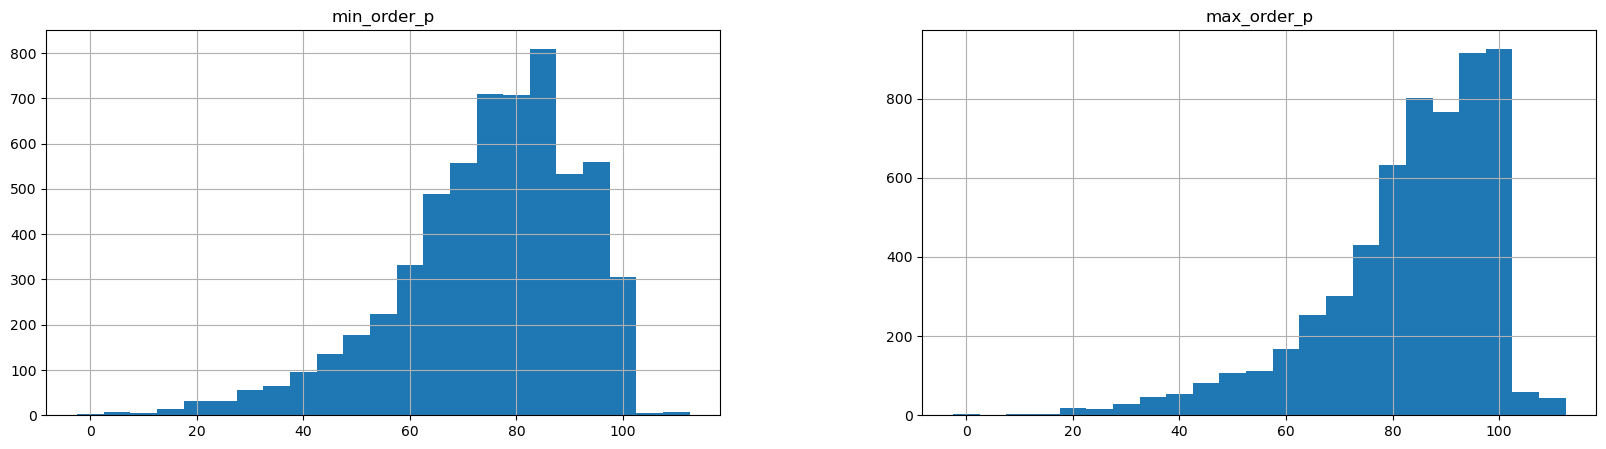

In [61]:
(
    products
    [lambda x: ~x.price.isna()]
    [lambda x: ~x.price.str.fullmatch(THREEDECIMALS)]
    .drop(columns=['in_stock','promo_price','type'])
    .assign(price=lambda x: pd.to_numeric(x.price))
    .join(unit_price_stats[['min','max']].rename(columns={'min': 'min_order', 'max': 'max_order'}), on='sku')
    #.join(unit_price_stats[['count','25%','75%']].rename(columns={'count': 'orders', '25%': 'min_order', '75%': 'max_order'}), on='sku')
    .assign(
        min_order_p = lambda x: x.min_order / x.price * 100,
        max_order_p = lambda x: x.max_order / x.price * 100,
        list_price_category = lambda x: np.select(
            [x.price < x.min_order, x.price <= x.max_order],
            ['below', 'between'],
            default='above')
    )
    .pipe(lambda x: [display(value_counts_and_proportion(x.list_price_category)), x][-1])
    [['min_order_p', 'max_order_p']]
    .hist(bins=[-2.5 + x for x in range(0,120,5)], figsize=(20,5))
)

> - most prices are clearly above the observed sales prices
> - in that sense, most products are always sold discounted
> - this does not really say whether they are temporarily discounted and allow to analyze discount impact

### Fix-up broken (three-decimal) `price` / `promo_price`

The approach for fixing the corrupted prices is assuming that the prices make sense in terms of the digits but that the decimal points are wrong. So, we remove the decimal point and determine the order of magnitude and consequently the new position for the decimal point from reference values. To do this, we use logarithm and exponentiation with base 10.

In the case of broken `price`, we are using the minimum and maximum observed unit-price from sales as the reference.

In the case of broken `promo_price`, we are using the (fixed) `price` and observed minimum unit-price from sales as the reference and use some heuristics two prevent unplausibly high or low `promo_price`.

In [62]:
def fixup_price(p, min_ref: float, max_ref: float):
    if not isinstance(p, str):
        return p
    if not re.fullmatch(THREEDECIMALS, p):
        return float(p)
    p = float(p.replace('.',''))
    fix_max = round(math.log10(max_ref*2/p))
    fix_min = round(math.log10(min_ref/2/p))
    p = p * (10 ** max([fix_min, fix_max]))
    return p

def fixup_promo_price(p, price_ref: float, min_ref: float):
    if not isinstance(p, str):
        return p
    if not re.fullmatch(THREEDECIMALS, p):
        return float(p)
    if np.isnan(price_ref):
        price_ref = min_ref
    p = float(p.replace('.',''))
    p *= 10 ** round(math.log10(price_ref/p))
    if not np.isnan(price_ref) and p > price_ref:
        p /= 10
    if p < min_ref/5:
        p *= 10
    return p

Apply the fix-up functions:

In [63]:
products = (
    products
    .assign(price_f = lambda x: x.apply(lambda r: fixup_price(r.price, *unit_price_stats.loc[r.sku, ['min', 'max']].to_list()), axis=1))
    .assign(promo_price_f = lambda x: x.apply(lambda r: fixup_promo_price(r.promo_price, r.price_f, unit_price_stats.loc[r.sku, 'min']), axis=1))
    .infer_objects()
)

Do a quality check on the fixed-up prices: Are they in the expected range w.r.t. observed sales prices?

In [64]:
(
    products
    .drop(columns=['in_stock', 'type'])
    .join(
        unit_price_stats
        [['min','max']]
        .rename(columns={'min': 'min_unit_price', 'max': 'max_unit_price'}),
        on='sku')
    .assign(
        price_f_good=lambda x:
            ~x.price.str.fullmatch(THREEDECIMALS) |
            x.price_f.between(x.min_unit_price * 0.8, x.max_unit_price * 2),
        promo_price_f_good=lambda x:
            (x.promo_price_f < x.max_unit_price * 2)
            & (x.promo_price_f < x.price_f * 1.5)
    )
    [['price_f_good','promo_price_f_good']]
    .pipe(value_counts_and_proportion)
)

,price_f_good,promo_price_f_good,count,proportion
0,True,True,6034,1.00
1,True,False,13,0.00
2,False,True,2,0.00


> - visual check reveals, the ones flagged as bad are in fact acceptable

In [65]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6049 entries, 0 to 19388
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sku            6049 non-null   object 
 1   name           6049 non-null   object 
 2   desc           6045 non-null   object 
 3   price          6049 non-null   object 
 4   promo_price    6049 non-null   object 
 5   in_stock       6049 non-null   int64  
 6   type           5977 non-null   object 
 7   price_f        6049 non-null   float64
 8   promo_price_f  6049 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 472.6+ KB


### Missing desc

In [66]:
products.desc.isna().value_counts()

desc
False    6045
True        4
Name: count, dtype: int64

In [67]:
products_orig[products_orig.desc.isna()]

,sku,name,desc,price,promo_price,in_stock,type
16126,WDT0211-A,"Open - Purple 2TB WD 35 ""PC Security Mac hard ...",NaN,107,814.659,0,1298
16128,APP1622-A,Open - Apple Smart Keyboard Pro Keyboard Folio...,NaN,1.568.206,1.568.206,0,1298
17843,PAC2334,Synology DS718 + NAS Server | 10GB RAM,NaN,566.35,5.659.896,0,12175397
18152,KAN0034-A,Open - Kanex USB-C Gigabit Ethernet Adapter Ma...,NaN,29.99,237.925,0,1298
18490,HTE0025,Hyper Pearl 1600mAh battery Mini USB Mirror an...,NaN,24.99,22.99,1,1515
18612,OTT0200,OtterBox External Battery Power Pack 20000 mAHr,NaN,79.99,56.99,1,1515
18690,HOW0001-A,Open - Honeywell thermostat Lyric zonificador ...,NaN,199.99,1.441.174,0,11905404


Just fill it with an empty string (irrelevant anyway)

In [68]:
products.loc[products.desc.isna(), 'desc'] = ''
products[products.desc.isna()]

,sku,name,desc,price,promo_price,in_stock,type,price_f,promo_price_f


### Missing type

In [69]:
value_counts_and_proportion(products.type.isna())

,type,count,proportion
0,False,5977,0.99
1,True,72,0.01


### Save cleaned data

In [70]:
(
    products
    .assign(
        price=lambda x: x.price_f.round(2),
        promo_price=lambda x: x.promo_price_f.round(2)
    )
    .drop(columns=['in_stock', 'price_f', 'promo_price_f'])
    .to_csv('products_cl.csv', index=False)
)

In [71]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6049 entries, 0 to 19388
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sku            6049 non-null   object 
 1   name           6049 non-null   object 
 2   desc           6049 non-null   object 
 3   price          6049 non-null   object 
 4   promo_price    6049 non-null   object 
 5   in_stock       6049 non-null   int64  
 6   type           5977 non-null   object 
 7   price_f        6049 non-null   float64
 8   promo_price_f  6049 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 472.6+ KB


In [72]:
pd.set_option('display.max_rows', 500)
products.type.value_counts()

type
11865403     714
1298         400
11935397     346
12175397     316
11905404     305
12635403     208
1364         181
13835403     162
12585395     158
1282         152
1296         132
5384         127
12215397     124
5,74E+15     123
1433         122
1325         122
5398          97
57445397      94
1334          87
1229          76
1,02E+12      74
12995397      71
13615399      68
12655397      60
1405          60
2449          59
1230          58
13555403      51
1515          50
2158          49
8696          46
14305406      37
51601716      37
1,44E+11      37
12645406      35
85651716      34
24895185      34
2,16E+11      32
21485407      32
85641716      31
5720          31
42945397      31
11821715      31
5395          30
1392          29
24215399      29
12755395      27
13005399      27
10230         27
2,17E+11      26
24885185      26
106431714     25
13855401      24
5,39E+11      24
5405          23
1216          23
10142         22
14365395      21
1387     